In [81]:
from pygeoinf.interval.function_providers import NormalModesProvider, BumpFunctionProvider
from pygeoinf.interval.interval_domain import IntervalDomain
from pygeoinf.interval.l2_space import L2Space
from pygeoinf.hilbert_space import EuclideanSpace, LinearOperator
from pygeoinf.interval.sola_operator import SOLAOperator
from pygeoinf.interval.l2_functions import Function
from pygeoinf.linear_solvers import CholeskySolver
from pygeoinf.gaussian_measure import GaussianMeasure
import matplotlib.pyplot as plt
import numpy as np

In [82]:
# Create a function domain and spaces
function_domain = IntervalDomain(0, 1)
M = L2Space(10, function_domain) # model space
N_d = 50 # number of data points
D = EuclideanSpace(N_d) # data space
N_p = 20 # number of property points
P = EuclideanSpace(N_p) # property space

In [83]:
# Create forward and property mappings
width = 0.2 # width of the bump target functions
centers = np.linspace(function_domain.a + width / 2, function_domain.b - width / 2, N_p) # centers of the bumps
# Create a normal modes provider for the forward operator
# and a bump function provider for the target operator
# Note: The random_state is set to ensure reproducibility of results
normal_modes_provider = NormalModesProvider(M, gaussian_width_percent_range=(5, 10),
                                            freq_range=(5, 10), random_state=39)
G = SOLAOperator(M, D, normal_modes_provider, integration_method='trapz', n_points=200)
target_provider = BumpFunctionProvider(M, centers=centers, default_width=width)
T = SOLAOperator(M, P, target_provider, integration_method='trapz', n_points=200)

/home/adrian/PhD/Inferences/pygeoinf/pygeoinf/interval/l2_functions.py:265: UserWarning: Point evaluation is not well-defined for general L² functions. Consider using a Sobolev space with s > 1/2 for point evaluation.
  warnings.warn(


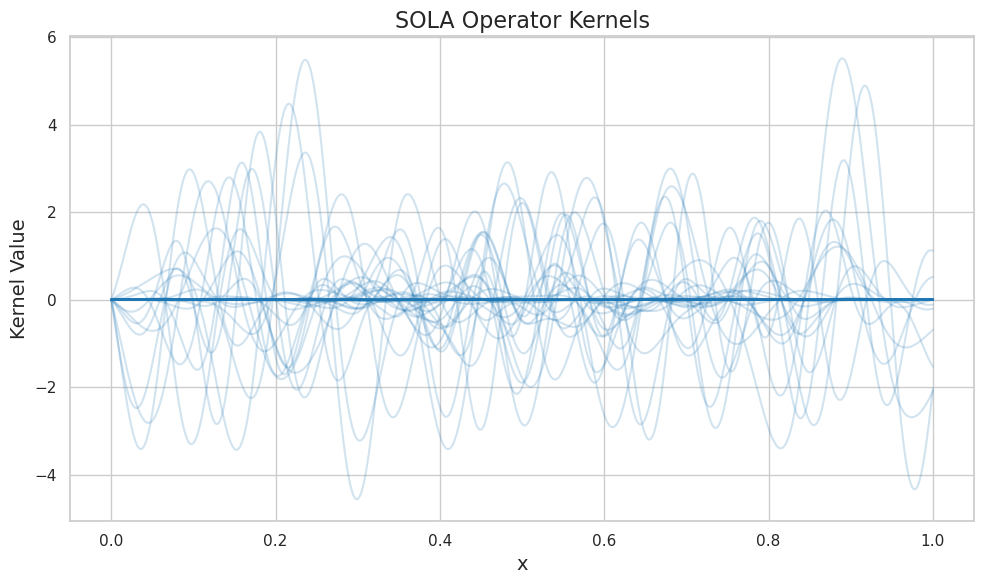

In [84]:
import seaborn as sns
sns.set(style="whitegrid", palette="muted", color_codes=True)
x = np.linspace(0, 1, 1000)
plt.figure(figsize=(10, 6))
for i in range(N_d):
    plt.plot(x, G.function_provider.get_function_by_index(i).evaluate(x), color='tab:blue', alpha=0.2)
plt.title('SOLA Operator Kernels', fontsize=16)
plt.xlabel('x', fontsize=14)
plt.ylabel('Kernel Value', fontsize=14)
plt.tight_layout()
plt.show()

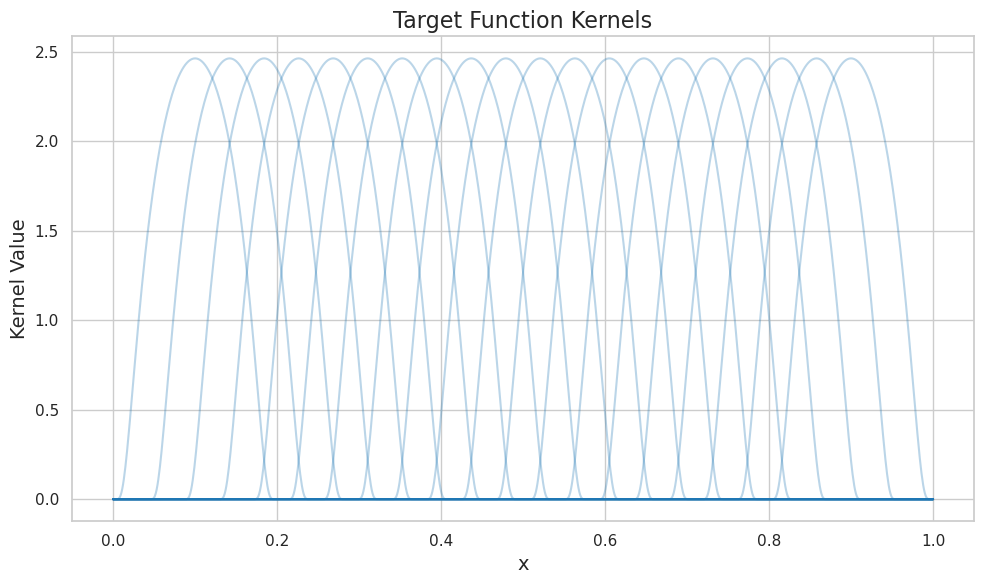

In [85]:
plt.figure(figsize=(10, 6))
for i in range(N_p):
    plt.plot(x, T.function_provider.get_function_by_index(i).evaluate(x), color='tab:blue', alpha=0.3)
plt.title('Target Function Kernels', fontsize=16)
plt.xlabel('x', fontsize=14)
plt.ylabel('Kernel Value', fontsize=14)
plt.tight_layout()
plt.show()

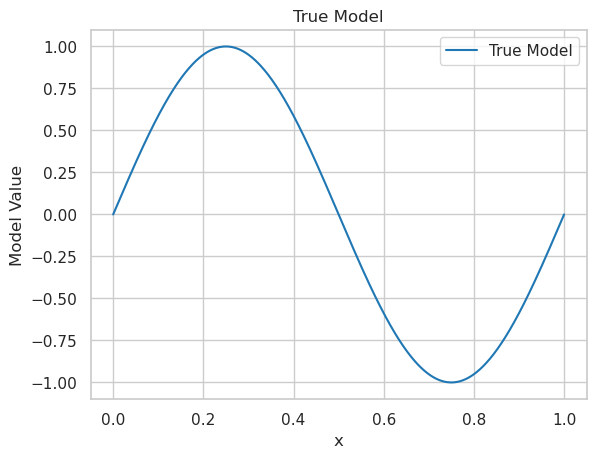

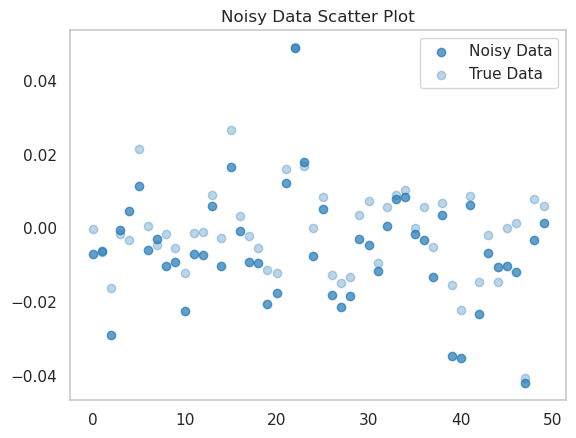

In [86]:
# Create a true model
m_bar = Function(M, evaluate_callable=lambda x: np.sin(2 * np.pi * x))
# Plot the true model
plt.plot(x, m_bar.evaluate(x), label='True Model', color='tab:blue')
plt.title('True Model')
plt.xlabel('x')
plt.ylabel('Model Value')
plt.legend()
plt.show()

# Create corresponding data
d_bar = G(m_bar)
# Create noisy data
d_tilde = d_bar + np.random.normal(-0.1*np.max(d_bar), 0.1*np.max(d_bar), d_bar.shape)

plt.scatter(np.arange(len(d_bar)), d_tilde, label='Noisy Data', color='tab:blue', alpha=0.7)
plt.scatter(np.arange(len(d_bar)), d_bar, label='True Data', color='tab:blue', alpha=0.3)
plt.grid()
plt.title('Noisy Data Scatter Plot')
plt.legend()
plt.show()

In [87]:
# Add Gaussian measure on data space
cov_D_matrix = np.eye(N_d) * 0.1 * np.max(d_tilde)  # covariance matrix for the noise

# Use from_covariance_matrix which automatically enables sampling
gaussian_D = GaussianMeasure.from_covariance_matrix(D, cov_D_matrix, expectation=d_tilde)

print(f"Gaussian measure on data space created with sampling enabled")
print(f"  Domain dimension: {gaussian_D.domain.dim}")
print(f"  Expectation shape: {gaussian_D.expectation.shape}")
print(f"  Sampling available: {gaussian_D.sample_set}")
print(f"  Covariance factor available: {gaussian_D.covariance_factor_set}")

Gaussian measure on data space created with sampling enabled
  Domain dimension: 50
  Expectation shape: (50,)
  Sampling available: True
  Covariance factor available: True


In [88]:
# Compute normal operator and the X operator
Lambda = LinearOperator.from_matrix(D, D, G.compute_gram_matrix())
cholesky_solver = CholeskySolver(galerkin=True)
W_inv = cholesky_solver(Lambda + gaussian_D.covariance)
G_inv = G.adjoint @ W_inv
X = T @ G_inv

In [89]:
# Compute both the model solution from the true data and the noisy data
m_tilde = G_inv(d_bar)
m_tilde_noisy = G_inv(d_tilde)

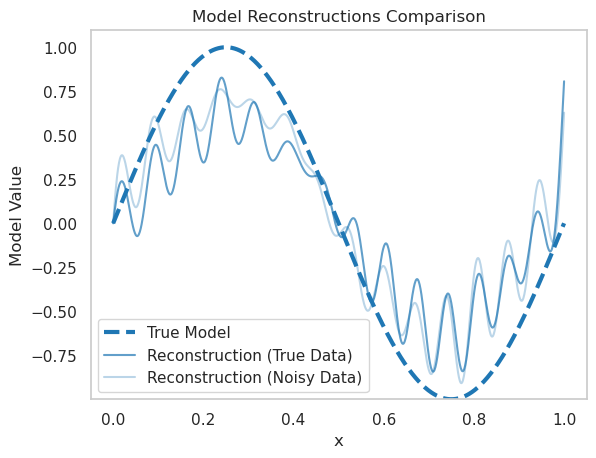

In [90]:
# Toggle to show/hide noisy reconstruction
show_noisy_reconstruction = True  # Set to True to show, False to hide
plt.plot(x, m_bar.evaluate(x), label='True Model', linestyle='--', color='tab:blue', linewidth=3)
plt.plot(x, m_tilde.evaluate(x), label='Reconstruction (True Data)', color='tab:blue', alpha=0.7, linewidth=1.5)
if show_noisy_reconstruction:
    plt.plot(x, m_tilde_noisy.evaluate(x), label='Reconstruction (Noisy Data)', color='tab:blue', alpha=0.3, linewidth=1.5)
plt.ylim(np.max(m_bar.evaluate(x)) * -1, np.max(m_bar.evaluate(x)) * 1.1)
plt.title('Model Reconstructions Comparison')
plt.xlabel('x')
plt.ylabel('Model Value')
plt.legend()
plt.grid()
plt.show()

In [91]:
# Compute the property values for the true model and the reconstructions
p_bar = T(m_bar) # true property
p_tilde = T(m_tilde) # property from true data
p_tilde_noisy = T(m_tilde_noisy) # property from noisy data

In [92]:
# Imposing unimodularity
M_one = Function(M, evaluate_callable=lambda x: np.ones_like(x))
v = G(M_one)
w = np.ones(N_p)
u = W_inv(v)
beta = D.inner_product(v, u)
correction = LinearOperator.from_matrix(D, P, np.outer((X(v) - w) / beta, u))
X_unimodular = X - correction

Alternatively, we can compute those from the property measure which is the push-forward of the data covariance through X

In [93]:
# Push forward the data measure through X to get property measure
# This automatically computes: mean = X(data_mean), covariance = X @ C_D @ X.adjoint
property_measure = gaussian_D.affine_mapping(operator=X)
property_measure_unimodular = gaussian_D.affine_mapping(operator=X_unimodular)


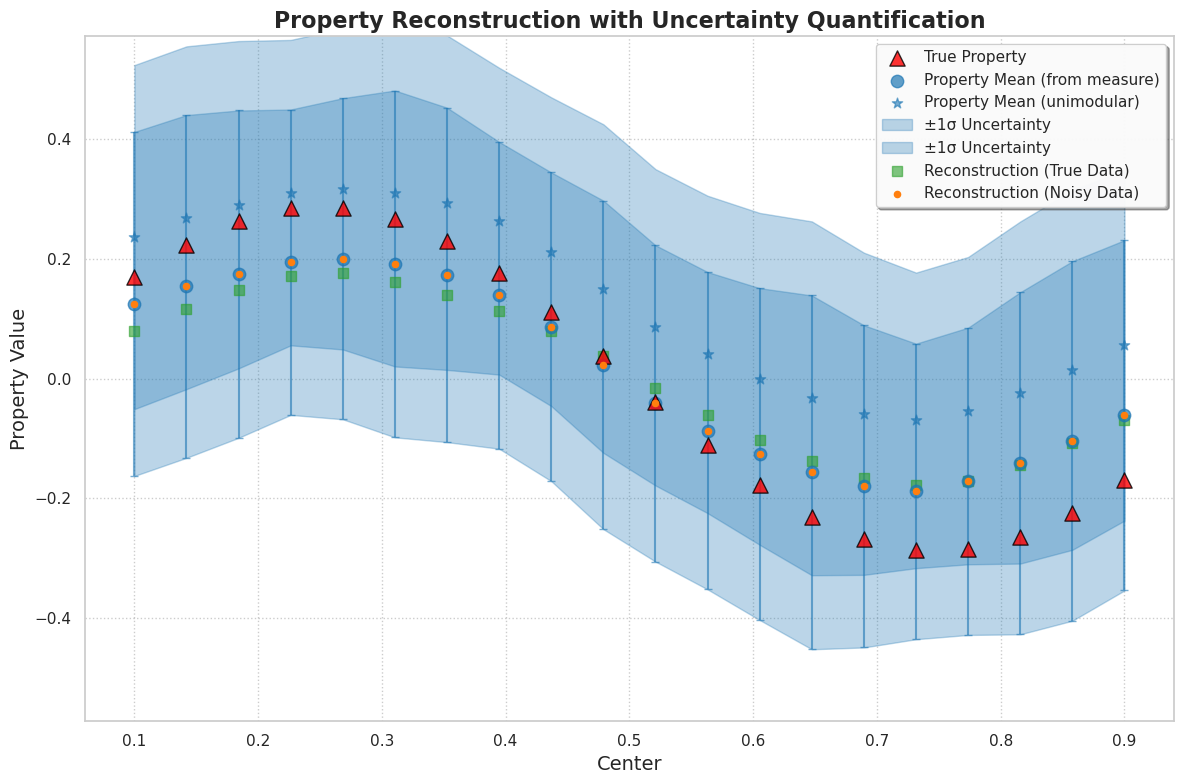

In [99]:
# Visualize property measure with uncertainty quantification
plt.figure(figsize=(12, 8))

# Get the mean from the property measure
p_mean = property_measure.expectation

# Compute standard deviations from the covariance matrix
# For each property point, get the diagonal element of the covariance
p_std = np.zeros(N_p)
for i in range(N_p):
    basis_vec = P.basis_vector(i)
    p_std[i] = np.sqrt(P.inner_product(property_measure.covariance(basis_vec), basis_vec))

# Create the main plot
plt.scatter(centers, p_bar, label='True Property', color='red', marker='^', s=120, edgecolor='black', alpha=0.8, zorder=5)
plt.scatter(centers, p_mean, label='Property Mean (from measure)', color='tab:blue', marker='o', s=80, alpha=0.7, zorder=4)
plt.scatter(centers, property_measure_unimodular.expectation, label='Property Mean (unimodular)', color='tab:blue', marker='*', s=60, alpha=0.6, zorder=3)

# Add uncertainty bands (mean ± 1 std)
plt.fill_between(centers, p_mean - p_std, p_mean + p_std,
                 alpha=0.3, color='tab:blue', label='±1σ Uncertainty', zorder=1)
plt.fill_between(centers, property_measure_unimodular.expectation - p_std, property_measure_unimodular.expectation + p_std,
                 alpha=0.3, color='tab:blue', label='±1σ Uncertainty', zorder=1)

# Add uncertainty error bars for better visibility
plt.errorbar(centers, p_mean, yerr=p_std, fmt='none', ecolor='tab:blue', alpha=0.6, capsize=3, zorder=2)

# Also show the deterministic reconstructions for comparison
plt.scatter(centers, p_tilde, label='Reconstruction (True Data)', color='tab:green', marker='s', s=60, alpha=0.6, zorder=3)
plt.scatter(centers, p_tilde_noisy, label='Reconstruction (Noisy Data)', color='tab:orange', marker='o', s=20, alpha=1, zorder=5)

plt.ylim(np.max(p_bar) * -2, np.max(p_bar) * 2)
plt.title('Property Reconstruction with Uncertainty Quantification', fontsize=16, fontweight='bold')
plt.xlabel('Center', fontsize=14)
plt.ylabel('Property Value', fontsize=14)
plt.grid(True, linestyle=':', alpha=0.4, color='gray')
plt.legend(fontsize=11, frameon=True, loc='upper right', fancybox=True, shadow=True, framealpha=0.95)
plt.tight_layout()
plt.show()